In [86]:
import math
import numpy as np
import matplotlib.pyplot as plt
from ptlpinns.models import train_PDE, model, transfer_kpp
from ptlpinns.odes import numerical
import torch

### Transfer parameters

In [87]:
L, T = 2, 5
x_span, t_span = (0, L), (0, T) 

Nx, Nt = 50, 50
x, t, grid = train_PDE.generate_interior_tensor(IG=(Nx, Nt), x_span=(0, L), t_span=(0, T), require_grad=False)

X_grid = np.linspace(0, L, Nx)
t_eval = np.linspace(0, T, Nt)
mesh_x, mesh_t = np.meshgrid(X_grid, t_eval)

In [88]:
D = 0.1
epsilon = 0.5
p = 5

def ic_sin(input):
    x = input[:, 0].unsqueeze(1)
    return (torch.sin(torch.pi * x / L))

def constant_function(constant):
    '''return a function input  ((x,t)in torch) -> constant, can be given as function.

    for example constant_function(0) will return a function that returns 0 for any input.
    '''
    def forcing_function_constant(input):
        return constant*torch.ones_like(input[:, 0].unsqueeze(1))
    return forcing_function_constant

ic = ic_sin
bcs = [constant_function(0), constant_function(0)] 
Polynomial = [[-1,1],[1,2]]
forcing=constant_function(0)

### Load the model

In [89]:
name = "model_KPP_Fisher_linear.pth"
path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/KPP_Fisher_linear"
pinn = model.Multihead_model_PDE(k=9, bias=True)
pinn.load_state_dict(torch.load(f'{path}/{name}'))

bias = True
w_pde, w_bc, w_ic = 1, 10, 10

training_log = {
    'name': name,
    'bias': bias,
    'k' : p,
    'domain_info':{
        'L': L,
        'T': T,},
    'Nx' : Nx,
    'Nt' : Nt,
    'w_pde': w_pde,
    'w_bc': w_bc,
    'w_ic': w_ic,}

### Validate Multi-head

In [90]:
H_dict = transfer_kpp.compute_H_dict(model = pinn, IG = (Nx,Nt), Nic = Nx,Nbc = Nt, bias = bias, x_span= x_span,t_span= t_span, D=D, log=training_log)

_, _, _ = transfer_kpp.compute_M(H_dict= H_dict,w_pde=w_pde,w_ic=w_ic,w_bc=w_bc)
_, H_dict = transfer_kpp.compute_R_ic(H_dict,ic_function=ic, w_ic=w_ic,log=training_log)
_,_,_,H_dict = transfer_kpp.compute_R_bcs(H_dict,boundary_functions=bcs ,w_bc=w_bc, log=training_log)

Differentiating H w.r.t. x now...


Finished computing H2x.
Differentiating H w.r.t. t now...
Finished computing Ht


In [91]:
input = torch.cat((x.unsqueeze(1), t.unsqueeze(1)), dim=1)  # Combine x and t into a single input tensor
NN_TL_pertubation_solution, _ = transfer_kpp.compute_perturbation_solution_polynomial_complete(p, epsilon,H_dict= H_dict, input=input,training_log= training_log, forcing=forcing,Polynomial=Polynomial,boundary_functions=bcs,ic_function=ic)
NN_TL_pertubation_solution = NN_TL_pertubation_solution.reshape(Nx, Nt)

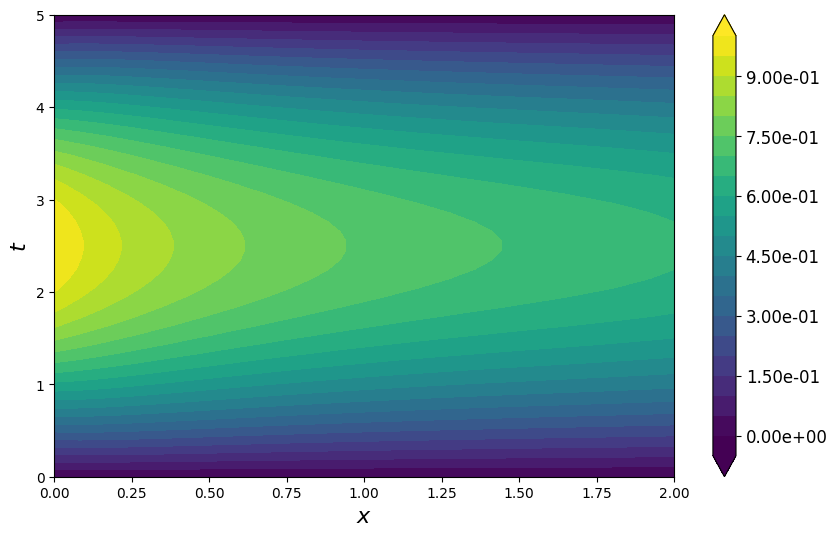

In [92]:
numerical.plot_solution_PDE(NN_TL_pertubation_solution, mesh_x, mesh_t, surface=False)

In [93]:
# KPP Fisher
epsilons = [epsilon]

def u_0_function(x):
    return (np.sin(np.pi * x / L))

u_0 = [u_0_function for _ in range(len(epsilons))]  
forcing = [lambda x, t: 0 for _ in range(len(epsilons))] 
bcs = [[lambda t: 0, lambda t: 0] for _ in range(len(epsilons))]  
polynomial = [lambda u: -u + u**2 for _ in range(len(epsilons))]

result_kpp = numerical.solution_KPP(epsilons, D, polynomial, x_span, t_span, Nx, Nt, u_0, forcing, bcs).squeeze()

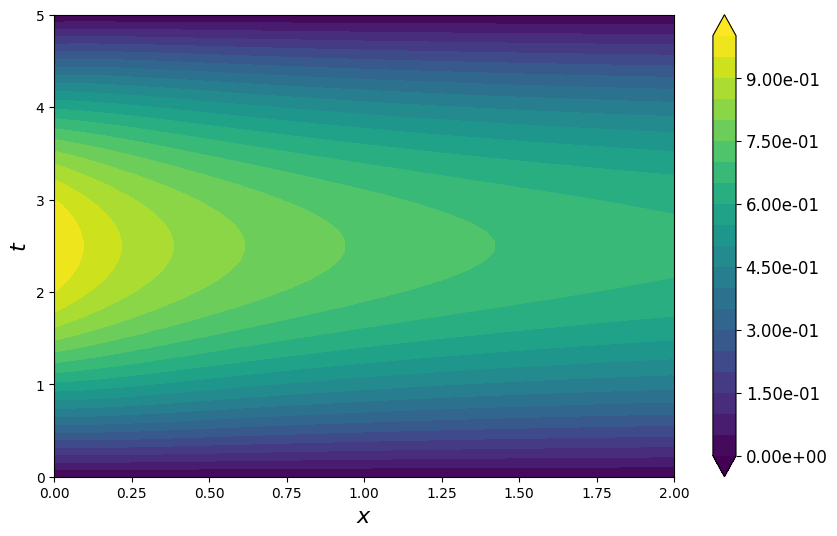

In [94]:
numerical.plot_solution_PDE(result_kpp, mesh_x, mesh_t, surface=False)

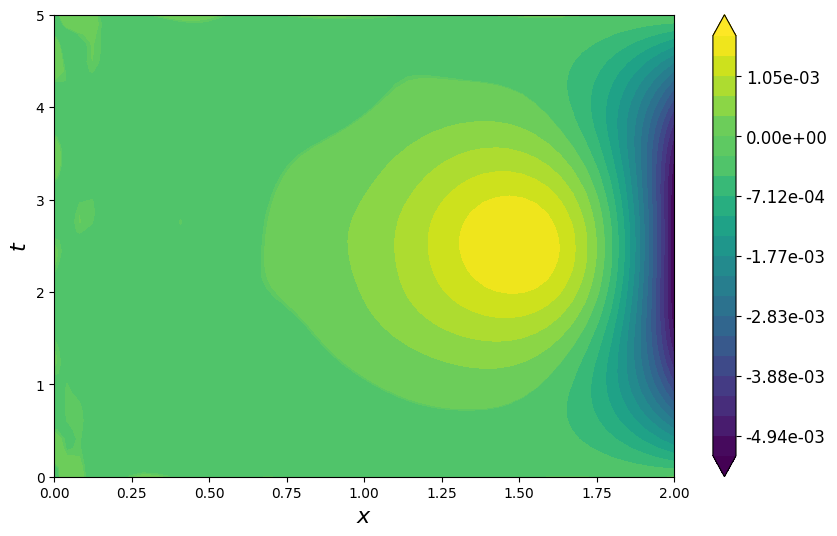

In [95]:
numerical.plot_solution_PDE(NN_TL_pertubation_solution - result_kpp, mesh_x, mesh_t, surface=False)

In [96]:
result_kpp_low_acc = numerical.solution_KPP(epsilons, D, polynomial, x_span, t_span, Nx, Nt, u_0, forcing, bcs, atol=1e-3, rtol=1e-3).squeeze()
np.mean(np.abs(result_kpp_low_acc - result_kpp))

np.float64(0.0004279033063147745)

In [97]:
result_kpp_low_acc = numerical.solution_KPP(epsilons, D, polynomial, x_span, t_span, Nx, Nt, u_0, forcing, bcs, atol=1e-3, rtol=1e-3, method="Radau").squeeze()
np.mean(np.abs(result_kpp_low_acc - result_kpp))

np.float64(1.9759930744005496e-05)

In [98]:
np.mean(np.abs(NN_TL_pertubation_solution - result_kpp))

np.float64(0.00046376886012661683)